# Introduction

User adoption rates are the lifeblood of any transportation business or program. The purpose of this analysis is to provide some insight behind the San Francisco Bike Share Program, to provide information for business decision makers to perform strategic planning when it comes to market expansion.

Marketing programs play a huge role market expansion and new user acquisition, so the focus of this analysis would be on providing recommendations for augmenting current marketing programs, as well as a user mapping visualization for monitoring rate of user adoption across different states in America. 

In [25]:
%matplotlib inline
import sqlite3
from pandasql import sqldf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil import parser
import xlrd
from pandas import ExcelWriter
from uszipcode import ZipcodeSearchEngine
import plotly.plotly as py

# df_trip_data_part1 = pd.read_sql_query("""
#                           select * from fact_trips 
#                           left join dim_stations on
#                           fact_trips.start_station_id = dim_stations.id
#                           left join (select * from dim_stations) as dim_stations_end on
#                           fact_trips.end_station_id = dim_stations_end.id
#                           left join (select id, entity_type as Subscriber_Type from dim_entity) as subscriber on
#                           fact_trips.entity_id = subscriber.id
#                           left join (select entity_id, zip_code from dim_entity_zip) as entity_zip_a on
#                           fact_trips.entity_id = entity_zip_a.entity_id
#                           ;
#                           """, 
#                           conn)

# get the zips database
zips = pd.io.parsers.read_csv('https://github.com/kh7393/bikesharing/blob/master/uszipsv1.1.csv?raw=true', dtype={'zip': 'str'})
zips['zip'] = zips.zip.astype(str)
zips.head()

,zip,lat,lng,city,state,zcta,parent_zcta,county_fips,county_name,county_weight,all_county_weights,imprecise,military
0,00501,40.8133,-73.0476,Holtsville,NY,False,11742.0,NaN,NaN,NaN,NaN,False,False
1,00544,40.8133,-73.0476,Holtsville,NY,False,11742.0,NaN,NaN,NaN,NaN,False,False
2,00601,18.1800,-66.7522,Adjuntas,PR,True,NaN,72001.0,Adjuntas,99.43,"{""72001"":99.43,""72141"":0.57}",False,False
3,00602,18.3607,-67.1752,Aguada,PR,True,NaN,72003.0,Aguada,100.00,"{""72003"":100}",False,False
4,00603,18.4566,-67.1226,Aguadilla,PR,True,NaN,72005.0,Aguadilla,100.00,"{""72005"":100}",False,False


In [3]:
df = pd.io.parsers.read_csv('201408_trip_data.csv', dtype={'Zip Code': 'str'})
df['Start Date'] = pd.to_datetime(df['Start Date'])
df['End Date'] = pd.to_datetime(df['End Date'])
df['Start Day of Week'] = df['Start Date'].dt.strftime('%A')
df['End Day of Week'] = df['End Date'].dt.strftime('%A')
df['Start Date Month'] = df['Start Date'].dt.strftime('%B')
df['End Date Month'] = df['End Date'].dt.strftime('%B')
df['Start Hour'] = df['Start Date'].dt.strftime('%H')
df['End Hour'] = df['End Date'].dt.strftime('%H')
df['Duration_parsed'] = pd.to_timedelta(df['Duration'], unit='m')
df['Route'] = df['Start Station'] + "-" + df['Start Terminal'].astype(str) + " -> " + df['End Station'] + "-" + df['End Terminal'].astype(str)
# -- prepare common join columns
zips.rename(columns=dict(zip='Zip Code',
                         city='subscriber_city'), 
            inplace=True)  
# specify join columns along with zips' columns to copy
cols = ['Zip Code', 'subscriber_city', 'state', 'lat', 'lng']
df = df.merge(zips[cols], how='left')
df.head()
df.apply(pd.Series.nunique)

Trip ID              171792
Duration               8329
Start Date            93171
Start Station            70
Start Terminal           70
End Date              92115
End Station              70
End Terminal             70
Bike #                  681
Subscriber Type           2
Zip Code               3526
Start Day of Week         7
End Day of Week           7
Start Date Month          6
End Date Month            7
Start Hour               24
End Hour                 24
Duration_parsed        8329
Route                  1677
subscriber_city        1284
state                    46
lat                    2545
lng                    2549
dtype: int64

# Analysis/Commentary

We have a total of 70 unique terminals in this program. We have 171,792 trips made over a span of 6 months, from March 2014 to August 2014. 

# Trip Duration

18.8752374965


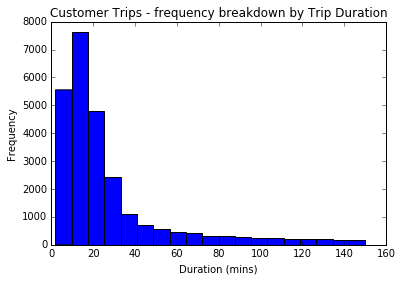

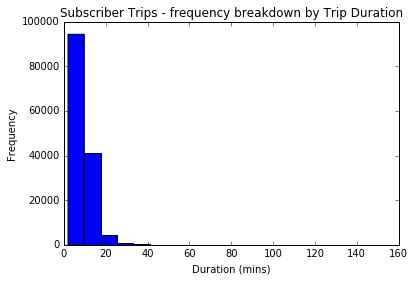

In [28]:
a = (df['Duration'].mean())/60
a = str(a)
print "The mean ride duration is " + a 

# get trip duration and breakdown by user type
df_filter_customer = df[df['Subscriber Type'] == 'Customer']
df_filter_customer_mins = df_filter_customer['Duration'] / 60
(df_filter_customer['Duration'].mean())
(df_filter_customer['Duration'].mean())/60

fig, ax = plt.subplots()
bins = np.linspace(2, 150, 20, endpoint=True)
plt.title('Customer Trips - frequency breakdown by Trip Duration')
plt.xlabel('Duration (mins)')
plt.ylabel('Frequency')
ax.hist(df_filter_customer_mins, bins, orientation='vertical')
plt.show()

df_filter_subscriber = df[df['Subscriber Type'] == 'Subscriber']
df_filter_subscriber_mins = df_filter_subscriber['Duration'] / 60
(df_filter_subscriber['Duration'].mean())
(df_filter_subscriber['Duration'].mean())/60

fig, ax = plt.subplots()
bins = np.linspace(2, 150, 20, endpoint=True)
plt.title('Subscriber Trips - frequency breakdown by Trip Duration')
plt.xlabel('Duration (mins)')
plt.ylabel('Frequency')
ax.hist(df_filter_subscriber_mins, bins, orientation='vertical')
plt.show()

The average trip takes about 18 minutes on the whole. However when we separate customers from subscribers, we can see that the average trip duration of customers is a lot higher than that of subscribers. They might be using bikes for different purposes. We will dig deeper to see if there are any more differences in user behaviour.

# Knowing our users

Start Day of Week  Subscriber Type
Friday             Customer            4032
                   Subscriber         23238
Monday             Customer            3141
                   Subscriber         25876
Saturday           Customer            5811
                   Subscriber          5626
Sunday             Customer            6019
                   Subscriber          5066
Thursday           Customer            3387
                   Subscriber         27253
Tuesday            Customer            3134
                   Subscriber         27944
Wednesday          Customer            3386
                   Subscriber         27879
Name: Trip ID, dtype: int64


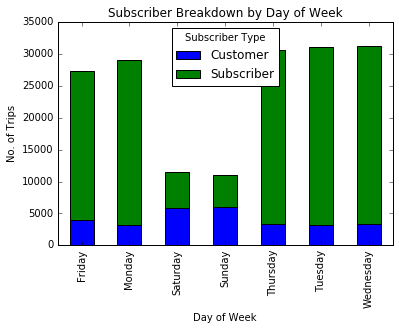

In [5]:
# plot user counts by subscriber type
user_breakdown = df.groupby(['Subscriber Type'])['Trip ID'].count()

# plot subscriber type vs day of week
day_of_week = df.groupby(['Start Day of Week', 'Subscriber Type'])['Trip ID'].count()
print day_of_week
day_of_week.unstack()
day_of_week_plot = day_of_week.unstack().plot(kind='bar',stacked=True,title="Subscriber Breakdown by Day of Week")
day_of_week_plot.set_xlabel("Day of Week")
day_of_week_plot.set_ylabel("No. of Trips")


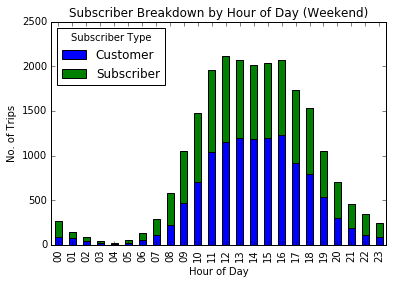

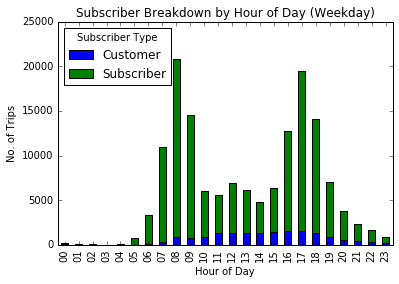

In [6]:
# plot subscriber type vs day of week (weekend)
weekend = ['Saturday', 'Sunday']
df_filter_weekend = df[df['Start Day of Week'].isin(weekend)]

hour_of_day_weekend = df_filter_weekend.groupby(['Start Hour', 'Subscriber Type'])['Trip ID'].count()
hour_of_day_weekend.unstack()
hour_of_day_weekend_plot = hour_of_day_weekend.unstack().plot(kind='bar',stacked=True,title="Subscriber Breakdown by Hour of Day (Weekend)")
hour_of_day_weekend_plot.set_xlabel("Hour of Day")
hour_of_day_weekend_plot.set_ylabel("No. of Trips")

# plot subscriber type vs day of week (weekday)
df_filter_weekday = df[~df['Start Day of Week'].isin(weekend)]

hour_of_day_weekday = df_filter_weekday.groupby(['Start Hour', 'Subscriber Type'])['Trip ID'].count()
hour_of_day_weekday.unstack()
hour_of_day_weekday_plot = hour_of_day_weekday.unstack().plot(kind='bar',stacked=True,title="Subscriber Breakdown by Hour of Day (Weekday)")
hour_of_day_weekday_plot.set_xlabel("Hour of Day")
hour_of_day_weekday_plot.set_ylabel("No. of Trips")

# Percentage share of customers vs subscribers
17% of trips are from customers. The remaining 83% are from subscribers. We might want to obtain revenue data for customers and subscribers for deeper analysis into revenue generated from each group. Also, we don't know the percentage of new vs repeat customers, or renewal rate of subscriptions. This may define the direction/priority for future customer acquisition or retention programs.

# Usage Trends

Customer usage peaks during weekends. In contrast, subscriber usage peaks during weekdays. This is valuable data for targeting different segments of users, be it via in-app push notifications, marketing campaigns, google adwords, re-marketing, and other data-driven campaigns. Of course, this could possibly have an effect on response rates for paid campaigns and/or ad spend.

Hour of day - weekends Usage peaks during the day. This is true for both customers and subscribers. Ridership decreases during weekends. This may be an opportunity for to target different segments of users - possibly leisure riders (or perhaps they are already switching to using Uber on weekends!)

Hour of day - weekdays Usage peaks during typical "rush hours" as expected - 7am - 9am, 4pm - 7pm

Such data would help for demand planning and forecasts to ensure sufficient bikes at the most popular terminals. It could even be possible to use the data for initial modeling of dynamic pricing, if deemed applicable to the country of interest.



# Most frequently used stations¶

In [7]:
# most popular stations - weekend, customer
station_weekend = pd.pivot_table(df_filter_weekend,index=['Start Station'],columns=['Subscriber Type'],values=['Trip ID'],aggfunc=[len])
station_weekend_customer = station_weekend[('len', 'Trip ID', 'Customer')]
print station_weekend_customer.nlargest(10)

station_weekend_end = pd.pivot_table(df_filter_weekend,index=['End Station'],columns=['Subscriber Type'],values=['Trip ID'],aggfunc=[len])
station_weekend_end_customer = station_weekend_end[('len', 'Trip ID', 'Customer')]
station_weekend_end_customer.nlargest(10)

Start Station
Harry Bridges Plaza (Ferry Building)    1349.0
Embarcadero at Sansome                  1298.0
Market at 4th                            464.0
Embarcadero at Vallejo                   416.0
Embarcadero at Bryant                    412.0
Powell at Post (Union Square)            407.0
Powell Street BART                       385.0
Steuart at Market                        356.0
2nd at Townsend                          344.0
Market at Sansome                        341.0
Name: (len, Trip ID, Customer), dtype: float64


End Station
Embarcadero at Sansome                      1677
Harry Bridges Plaza (Ferry Building)        1100
Market at 4th                                525
Powell Street BART                           470
Embarcadero at Vallejo                       466
Steuart at Market                            464
Powell at Post (Union Square)                402
Grant Avenue at Columbus Avenue              381
San Francisco Caltrain (Townsend at 4th)     351
2nd at Townsend                              347
Name: (len, Trip ID, Customer), dtype: int64

In [8]:
# most popular stations - weekend, subscriber
station_weekend_subscriber = station_weekend[('len', 'Trip ID', 'Subscriber')]
print station_weekend_subscriber.nlargest(10)

station_weekend_end_customer = station_weekend_end[('len', 'Trip ID', 'Subscriber')]
station_weekend_end_customer.nlargest(10)

Start Station
Harry Bridges Plaza (Ferry Building)        575.0
San Francisco Caltrain (Townsend at 4th)    506.0
Embarcadero at Bryant                       492.0
2nd at Townsend                             489.0
Embarcadero at Sansome                      488.0
Townsend at 7th                             423.0
Market at 4th                               421.0
Powell Street BART                          377.0
Grant Avenue at Columbus Avenue             347.0
Civic Center BART (7th at Market)           325.0
Name: (len, Trip ID, Subscriber), dtype: float64


End Station
Harry Bridges Plaza (Ferry Building)        645
San Francisco Caltrain (Townsend at 4th)    588
2nd at Townsend                             496
Embarcadero at Sansome                      488
Market at 4th                               478
Embarcadero at Bryant                       470
Powell Street BART                          451
Townsend at 7th                             441
Civic Center BART (7th at Market)           341
Market at Sansome                           327
Name: (len, Trip ID, Subscriber), dtype: int64

In [9]:
# most popular stations - weekday, customer
station_weekday = pd.pivot_table(df_filter_weekday,index=['Start Station'],columns=['Subscriber Type'],values=['Trip ID'],aggfunc=[len])
station_weekday_customer = station_weekday[('len', 'Trip ID', 'Customer')]
print station_weekday_customer.nlargest(10)

station_weekday_end = pd.pivot_table(df_filter_weekday,index=['End Station'],columns=['Subscriber Type'],values=['Trip ID'],aggfunc=[len])
station_weekday_end_customer = station_weekday_end[('len', 'Trip ID', 'Customer')]
station_weekday_end_customer.nlargest(10)

Start Station
Embarcadero at Sansome                      1704
Harry Bridges Plaza (Ferry Building)        1386
Market at 4th                                744
Powell Street BART                           698
Embarcadero at Vallejo                       630
San Francisco Caltrain (Townsend at 4th)     608
Powell at Post (Union Square)                594
2nd at Townsend                              591
Steuart at Market                            577
Market at Sansome                            482
Name: (len, Trip ID, Customer), dtype: int64


End Station
Embarcadero at Sansome                      2206
Harry Bridges Plaza (Ferry Building)        1176
San Francisco Caltrain (Townsend at 4th)     785
Powell Street BART                           714
Market at 4th                                661
Steuart at Market                            623
2nd at Townsend                              602
Powell at Post (Union Square)                598
Embarcadero at Vallejo                       579
Grant Avenue at Columbus Avenue              499
Name: (len, Trip ID, Customer), dtype: int64

In [10]:
# most popular stations - weekday, subscriber
station_weekday_subscriber = station_weekday[('len', 'Trip ID', 'Subscriber')]
print station_weekday_subscriber.nlargest(10)

station_weekday_end_customer = station_weekday_end[('len', 'Trip ID', 'Subscriber')]
station_weekday_end_customer.nlargest(10)

Start Station
San Francisco Caltrain (Townsend at 4th)         11571
San Francisco Caltrain 2 (330 Townsend)           6248
Temporary Transbay Terminal (Howard at Beale)     6177
Market at Sansome                                 5701
2nd at Townsend                                   5400
Steuart at Market                                 5087
Harry Bridges Plaza (Ferry Building)              5026
Townsend at 7th                                   4612
2nd at South Park                                 3863
Market at 10th                                    3857
Name: (len, Trip ID, Subscriber), dtype: int64


End Station
San Francisco Caltrain (Townsend at 4th)         15008
Market at Sansome                                 6858
San Francisco Caltrain 2 (330 Townsend)           6792
2nd at Townsend                                   5966
Temporary Transbay Terminal (Howard at Beale)     5421
Townsend at 7th                                   5251
Steuart at Market                                 4989
Harry Bridges Plaza (Ferry Building)              4987
Powell Street BART                                3813
Embarcadero at Sansome                            3770
Name: (len, Trip ID, Subscriber), dtype: int64

The most frequently used stations differ between weekdays and weekends, so these differences should be considered when planning for demand at the respective stations, depending on the day of the week. Caltrain users seem to use the bike-sharing program more than users from other parts of the city. We should explore why this is the case, and see if there is a business case for more targeted campaigns to woo users from other areas.

In [11]:
# top 10 users by city
user_city = pd.pivot_table(df, index=['subscriber_city'], values=['Trip ID'], aggfunc=[len])
user_city = user_city.sort_values(('len', 'Trip ID'), ascending=False).head(10)
print user_city

                    len
                Trip ID
subscriber_city        
San Francisco     76594
San Jose          10891
Oakland            9583
San Mateo          5248
Mountain View      4866
Berkeley           3829
Redwood City       3005
Palo Alto          2894
Sunnyvale          2251
Alameda            1836


In [12]:
# top 10 routes
user_routes = pd.pivot_table(df, index=['Route'], values=['Trip ID'], aggfunc=[len])
user_routes.sort_values(('len', 'Trip ID'), ascending=False).head(10)

,len
,Trip ID
Route,
Harry Bridges Plaza (Ferry Building)-50 -> Embarcadero at Sansome-60,1689
Townsend at 7th-65 -> San Francisco Caltrain (Townsend at 4th)-70,1527
San Francisco Caltrain 2 (330 Townsend)-69 -> Townsend at 7th-65,1352
Embarcadero at Sansome-60 -> Steuart at Market-74,1128
2nd at Townsend-61 -> Harry Bridges Plaza (Ferry Building)-50,1109
2nd at South Park-64 -> Market at Sansome-77,1039
Harry Bridges Plaza (Ferry Building)-50 -> 2nd at Townsend-61,1007
Market at 10th-67 -> San Francisco Caltrain (Townsend at 4th)-70,974



It is interesting to note that the 2nd and 3rd routes seem to revolve around the same start/end stations. It might be worth investigating why this is so, based on external sources we know that Townsend seems to be a major business district. Offline marketing roadshows or promos could be run in this area, or a corporate package could even be created for employees of these companies to increase adoption of the bike share program.

# Monthly trends

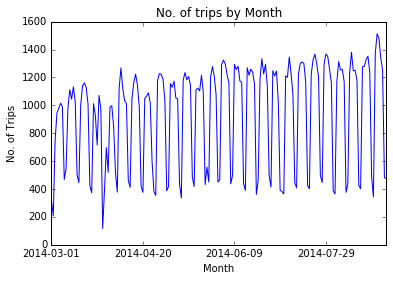

In [13]:
# monthly trends - number of trips
df['Start Date_Short'] = df['Start Date'].dt.strftime('%Y-%m-%d')
monthly_trips = df.groupby(['Start Date_Short'])['Trip ID'].count()
monthly_trips_plot = monthly_trips.plot(title="No. of trips by Month")
monthly_trips_plot.set_xlabel("Month")
monthly_trips_plot.set_ylabel("No. of Trips")

The number of trips increased slightly from March to July. Fluctuations are mainly due to the differences between weekdays and weekends but we are able to perform more detailed analysis if we can correct for holidays or major events such as sports matches.

# Visualization in Tableau

Please use this link if the embedded Tableau dashboard doesn't display properly:
https://public.tableau.com/views/BikeShareProgramViz/Dashboard1?:embed=y&:display_count=yes

In [30]:
%%HTML

<div class='tableauPlaceholder' id='viz1489568058570' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Bi&#47;BikeShareProgramViz&#47;Dashboard1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='site_root' value='' /><param name='name' value='BikeShareProgramViz&#47;Dashboard1' /><param name='tabs' value='yes' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Bi&#47;BikeShareProgramViz&#47;Dashboard1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1489568058570');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.minWidth='424px';vizElement.style.maxWidth='1454px';vizElement.style.width='100%';vizElement.style.minHeight='655px';vizElement.style.maxHeight='955px';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

We will be able to track the number of users (customers/subscribers) over time using the Tableau visualization, as well as the areas they originated from. This could be a means of tracking the impact of recommendations given for business strategy and marketing campaigns. 

For example, we will know if we have managed to attract users from different parts of US, or whether we managed to acquire new subscribers from within San Francisco. It will be updated with new data via SQL queries and the python scripts run on a regular basis, or even daily via cron jobs.

# Recommendations

We saw in the visualization that most users of the Bike Share Program are based in San Francisco, by subscribers who accounted for 83% of total trips, for short rides. This appears to fit the typical behaviour of commuters. In San Francisco itself, users from Caltrain seem to use the system most. 

Users who are customers seem to fit the typical behaviour of tourists, since they frequently visit on weekends and they come from many different parts of the United States. They don't seem to ride around business districts unlike commuters.

So, we should take these into account when designing offline promotion or marketing tactics such as sign-up booths to acquire more new subscribers/customers. Of course, this could also be used for planning and accommodating demand by building more stations in locations with high number of users.

Here are some marketing/user acquisition-related recommendations after this analysis:

1. We should run investigative studies see if we can incorporate weather, day of week, time of day, user type into predictive models together with Google Adwords/Programmatic advertising campaign data. We may be able to optimize bids and conversion rates with these data.

2. We could look into location-based campaigns for subscribers - these will be San-Francisco specific. For customers, campaigns can be targeted to most states in America. It could be possible to increase new customer/subscriber acquisition quickly by placing ads/content for people in the cities of frequently used terminals, then gradually move towards areas with fewer customers/subscribers. 

3. Email/Website personalization - if we are able to identify customers/subscribers on any bike sharing app, website or within marketing automation systems, we can create marketing segments and display personalized content that is more relevant to them, given that tourists and commuters would use bikes for different purposes.

4. We should look into creating specialized content and landing pages to target these 2 segments of users in a more specific manner. For example, tourists and commuters are likely to be interested in different topics.

5. We should use the visualization to create marketing plans for new user acquisition in surrouding regions, be it via online or offline tactics.

6. We could look into offering different types of bicycles at different price points to different user types - perhaps road bikes vs normal city bikes.

# Limitations/Future Improvements

The analysis is limited by the amount of data available, with more data, possibly from external sources as well as web analytics/marketing campaign data, more investigations and suggestions could be made with respect to marketing campaigns or growth strategy.

Public holidays & Weather - intuition suggests that usage would plummet during rainy or inclement weather. If we are able to obtain conversion data on marketing campaigns, we could see if the weather impacts conversion rates on ads. This might be an opportunity to optimize or limit ad spend on programmatic advertising tactics such as Google Adwords (using scripts) or DoubleClick.

Complete zipcode databases may not be available in other countries, unlike in US. So more effort may be required if we are to replicate this analysis in other countries.
